Writing images at iteration 0
Writing images at iteration 20
Writing images at iteration 40
Writing images at iteration 60
Writing images at iteration 80
Writing images at iteration 100
Writing images at iteration 120
Writing images at iteration 140
Writing images at iteration 160
Writing images at iteration 180
Writing images at iteration 200
Writing images at iteration 220
Writing images at iteration 240
Writing images at iteration 260
Writing images at iteration 280
Writing images at iteration 300
Writing images at iteration 320
Writing images at iteration 340
Writing images at iteration 360
Writing images at iteration 380
Writing images at iteration 400
Writing images at iteration 420
Writing images at iteration 440
Writing images at iteration 460
Writing images at iteration 480
Writing images at iteration 500
Writing images at iteration 520
Writing images at iteration 540
Writing images at iteration 560
Writing images at iteration 580
Writing images at iteration 600
Writing images

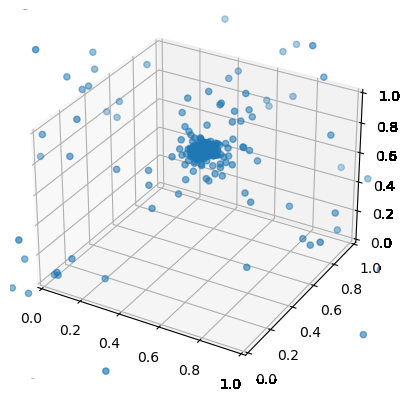

In [1]:
# Simple Python implementation of a Barnes-Hut galaxy simulator.
# This file is part of the exercise series of the University of Geneva's
# MOOC "Simulation and Modeling of Natural Processes".
#
# Author: Jonas Latt
# E-mail contact: jonas.latt@unige.ch
# Important: don't send questions about this code to the above e-mail address.
# They will remain unanswered. Instead, use the resources of the MOOC.
# 
# Copyright (C) 2016 University of Geneva
# 24 rue du Général-Dufour
# CH - 1211 Genève 4
# Switzerland
#
# This code is free software: you can redistribute it and/or
# modify it under the terms of the GNU General Public License as
# published by the Free Software Foundation, either version 3 of the
# License, or (at your option) any later version.
#
# The code is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

from copy import deepcopy
from numpy import array
from numpy.linalg import norm
from numpy import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class Node:
# A node represents a body if it is an endnote (i.e. if node.child is None)
# or an abstract node of the quad-tree if it has child.

    def __init__(self, m, x, y, z):
    # The initializer creates a child-less node (an actual body).
        self.m = m
        # Instead of storing the position of a node, we store the mass times
        # position, m_pos. This makes it easier to update the center-of-mass.
        self.m_pos = m * array([x, y, z])
        self.momentum = array([0., 0., 0.])
        self.child = None

    def into_next_quadrant(self):
    # Places node into next-level quadrant and returns the quadrant number.
        self.s = 0.5 * self.s   # s: side-length of current quadrant.
        return self._subdivide(1) + 2*self._subdivide(0)

    def pos(self):
    # Physical position of node, independent of currently active quadrant.
        return self.m_pos / self.m

    def reset_to_0th_quadrant(self):
    # Re-positions the node to the level-0 quadrant (full domain).
        # Side-length of the level-0 quadrant is 1.
        self.s = 1.0
        # Relative position inside the quadrant is equal to physical position.
        self.relpos = self.pos().copy()

    def dist(self, other):
    # Distance between present node and another node.
        return norm(other.pos() - self.pos())

    def force_on(self, other):
    # Force which the present node is exerting on a given body.
        # To avoid numerical instabilities, introduce a short-distance cutoff.
        cutoff_dist = 0.002
        d = self.dist(other)
        if d < cutoff_dist:
            return array([0., 0., 0.])
        else:
            # Gravitational force goes like 1/r**2.
            return (self.pos() - other.pos()) * (self.m*other.m / d**3)

    def _subdivide(self, i):
    # Places node into next-level quadrant along direction i and recomputes
    # the relative position relpos of the node inside this quadrant.
        self.relpos[i] *= 2.0
        if self.relpos[i] < 1.0:
            quadrant = 0
        else:
            quadrant = 1
            self.relpos[i] -= 1.0
        return quadrant


def add(body, node):
# Barnes-Hut algorithm: Creation of the quad-tree. This function adds
# a new body into a quad-tree node. Returns an updated version of the node.
    # 1. If node n does not contain a body, put the new body b here.
    new_node = body if node is None else None
    # To limit the recursion depth, set a lower limit for the size of quadrant.
    smallest_quadrant = 1.e-4
    if node is not None and node.s > smallest_quadrant:
        # 3. If node n is an external node, then the new body b is in conflict
        #    with a body already present in this region. ...
        if node.child is None:
            new_node = deepcopy(node)
        #    ... Subdivide the region further by creating four children
            new_node.child = [None for i in range(4)]
        #    ... And to start with, insert the already present body recursively
        #        into the appropriate quadrant.
            quadrant = node.into_next_quadrant()
            new_node.child[quadrant] = node
        # 2. If node n is an internal node, we don't to modify its child.
        else:
            new_node = node

        # 2. and 3. If node n is or has become an internal node ...
        #           ... update its mass and "center-of-mass times mass".
        new_node.m += body.m
        new_node.m_pos += body.m_pos
        # ... and recursively add the new body into the appropriate quadrant.
        quadrant = body.into_next_quadrant()
        new_node.child[quadrant] = add(body, new_node.child[quadrant])
    return new_node


def force_on(body, node, theta):
# Barnes-Hut algorithm: usage of the quad-tree. This function computes
# the net force on a body exerted by all bodies in node "node".
# Note how the code is shorter and more expressive than the human-language
# description of the algorithm.
    # 1. If the current node is an external node, 
    #    calculate the force exerted by the current node on b.
    if node.child is None:
        return node.force_on(body)

    # 2. Otherwise, calculate the ratio s/d. If s/d < θ, treat this internal
    #    node as a single body, and calculate the force it exerts on body b.
    if node.s < node.dist(body) * theta:
        return node.force_on(body)

    # 3. Otherwise, run the procedure recursively on each child.
    return sum(force_on(body, c, theta) for c in node.child if c is not None)


def verlet(bodies, root, theta, G, dt):
# Execute a time iteration according to the Verlet algorithm.
    for body in bodies:
        force = G * force_on(body, root, theta)
        body.momentum += dt * force
        body.m_pos += dt * body.momentum 


def plot_bodies(bodies, i):
# Write an image representing the current position of the bodies.
# To create a movie with avconv or ffmpeg use the following command:
# ffmpeg -r 15 -i bodies3D_%06d.png -q:v 0 bodies3D.avi
    ax = plt.gcf().add_subplot(111, projection='3d')
    ax.scatter([b.pos()[0] for b in bodies], \
    [b.pos()[1] for b in bodies], [b.pos()[2] for b in bodies])
    ax.set_xlim([0., 1.0])
    ax.set_ylim([0., 1.0])
    ax.set_zlim([0., 1.0])    
    plt.gcf().savefig('bodies3D_{0:06}.png'.format(i))


######### MAIN PROGRAM ########################################################

# Theta-criterion of the Barnes-Hut algorithm.
theta = 0.5
# Mass of a body.
mass = 1.0
# Initially, the bodies are distributed inside a circle of radius ini_radius.
ini_radius = 0.1
# Initial maximum velocity of the bodies.
inivel = 0.1
# The "gravitational constant" is chosen so as to get a pleasant output.
G = 4.e-6
# Discrete time step.
dt = 1.e-3
# Number of bodies (the actual number is smaller, because all bodies
# outside the initial radius are removed).
numbodies = 1000
# Number of time-iterations executed by the program.
max_iter = 10000
# Frequency at which PNG images are written.
img_iter = 20

# The pseudo-random number generator is initialized at a deterministic # value, for proper validation of the output for the exercise series.  random.seed(1)
# x- and y-pos are initialized to a square with side-length 2*ini_radius.
random.seed(1)
posx = random.random(numbodies) *2.*ini_radius + 0.5-ini_radius
posy = random.random(numbodies) *2.*ini_radius + 0.5-ini_radius
posz = random.random(numbodies) *2.*ini_radius + 0.5-ini_radius
# We only keep the bodies inside a circle of radius ini_radius.
bodies = [ Node(mass, px, py, pz) for (px,py,pz) in zip(posx, posy, posz) \
               if (px-0.5)**2 + (py-0.5)**2 + (pz-0.5)**2 < ini_radius**2 ]

#input("Press the <ENTER> key to continue...")
#print ("here")
# Initially, the bodies have a radial velocity of an amplitude proportional to
# the distance from the center. This induces a rotational motion creating a
# "galaxy-like" impression.
for body in bodies: 
    r = body.pos() - array([0.5, 0.5, body.pos()[2] ])
    body.momentum = array([-r[1], r[0], 0.]) * \
    mass*inivel*norm(r)/ini_radius

# Principal loop over time iterations.
for i in range(max_iter):
    # The quad-tree is recomputed at each iteration.
    root = None
    for body in bodies:
        body.reset_to_0th_quadrant()
        root = add(body, root)
    # Computation of forces, and advancment of bodies.
    verlet(bodies, root, theta, G, dt)
    # Output
           
    if i%img_iter==0:
        print("Writing images at iteration {0}".format(i))
        plot_bodies(bodies, i//img_iter)

In [3]:
bodies[500].pos()

array([0.52048327, 0.48564288, 0.80691199])

In [5]:
from copy import deepcopy
from numpy import array
from numpy.linalg import norm
from numpy import random

class Node:
    def __init__(self, m, x, y, z):
        self.m = m
        self.m_pos = m * array([x, y, z])
        self.momentum = array([0., 0., 0.])
        self.child = None

    def into_next_quadrant(self):
        self.s = 0.5 * self.s
        return self._subdivide(1) + 2*self._subdivide(0)

    def pos(self):
        return self.m_pos / self.m

    def reset_to_0th_quadrant(self):
        self.s = 1.0
        self.relpos = self.pos().copy()

    def dist(self, other):
        return norm(other.pos() - self.pos())

    def force_on(self, other):
        cutoff_dist = 0.002
        d = self.dist(other)
        if d < cutoff_dist:
            return array([0., 0., 0.])
        else:
            return (self.pos() - other.pos()) * (self.m*other.m / d**3)

    def _subdivide(self, i):
        self.relpos[i] *= 2.0
        if self.relpos[i] < 1.0:
            quadrant = 0
        else:
            quadrant = 1
            self.relpos[i] -= 1.0
        return quadrant


def add(body, node):
    new_node = body if node is None else None
    smallest_quadrant = 1.e-4
    if node is not None and node.s > smallest_quadrant:
        if node.child is None:
            new_node = deepcopy(node)
            new_node.child = [None for i in range(4)]
            quadrant = node.into_next_quadrant()
            new_node.child[quadrant] = node
        else:
            new_node = node

        new_node.m += body.m
        new_node.m_pos += body.m_pos
        quadrant = body.into_next_quadrant()
        new_node.child[quadrant] = add(body, new_node.child[quadrant])
    return new_node


def force_on(body, node, theta):
    if node.child is None:
        return node.force_on(body)

    if node.s < node.dist(body) * theta:
        return node.force_on(body)

    return sum(force_on(body, c, theta) for c in node.child if c is not None)


def verlet(bodies, root, theta, G, dt):
    for body in bodies:
        force = G * force_on(body, root, theta)
        body.momentum += dt * force
        body.m_pos += dt * body.momentum


######### MAIN PROGRAM ########################################################

theta = 0.5
mass = 1.0
ini_radius = 0.1
inivel = 0.1
G = 4.e-6
dt = 1.e-3
numbodies = 1000
max_iter = 10000

random.seed(1)
posx = random.random(numbodies) * 2.*ini_radius + 0.5 - ini_radius
posy = random.random(numbodies) * 2.*ini_radius + 0.5 - ini_radius
posz = random.random(numbodies) * 2.*ini_radius + 0.5 - ini_radius
bodies = [Node(mass, px, py, pz) for (px, py, pz) in zip(posx, posy, posz)
          if (px-0.5)**2 + (py-0.5)**2 + (pz-0.5)**2 < ini_radius**2]

for body in bodies:
    r = body.pos() - array([0.5, 0.5, body.pos()[2]])
    body.momentum = array([-r[1], r[0], 0.]) * mass * inivel * norm(r) / ini_radius

for i in range(502): # Only iterate up to 501
    root = None
    for body in bodies:
        body.reset_to_0th_quadrant()
        root = add(body, root)
    verlet(bodies, root, theta, G, dt)
    z_component = bodies[0].pos()[2]
    print(f"At iteration i={i}, the z-component of the position of the first body is:", z_component)

At iteration i=0, the z-component of the position of the first body is: 0.5153954282820885
At iteration i=1, the z-component of the position of the first body is: 0.5153951462541966
At iteration i=2, the z-component of the position of the first body is: 0.5153947232101173
At iteration i=3, the z-component of the position of the first body is: 0.5153941591475042
At iteration i=4, the z-component of the position of the first body is: 0.5153934540696411
At iteration i=5, the z-component of the position of the first body is: 0.5153926079729051
At iteration i=6, the z-component of the position of the first body is: 0.5153916208530345
At iteration i=7, the z-component of the position of the first body is: 0.5153904927051286
At iteration i=8, the z-component of the position of the first body is: 0.5153892235236479
At iteration i=9, the z-component of the position of the first body is: 0.5153878133024139
At iteration i=10, the z-component of the position of the first body is: 0.515386262034609